# Model Testing and Exploration
This script was used for exploring various model architectures as well as validating and generating plots from the Optuna trials.

Due to the messy nature of iteration, most of the trials were conducted by commenting in and out code rather than creating new blocks. The trials are best summarized in the report, as notes and data were collected in external note-taking apps rather than on this notebook. This notebook is being submitted anyway for bookkeeping purposes.

In [22]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

In [23]:
DEVICE = "mps"
DEVICE

'mps'

# Setup the problem
This is all the same as Week 3 MLP tutorial.

In [24]:
def get_mnist():

    # Any data augmentation should be added to training
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.RandomAffine(25),
        transforms.ElasticTransform(alpha=70.0),
        transforms.Normalize(mean=0.1307, std=0.3081),
    ])

    # Test data should have normalization applied, but no augmentation
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    # Load FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.MNIST(DIR, train=False, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader

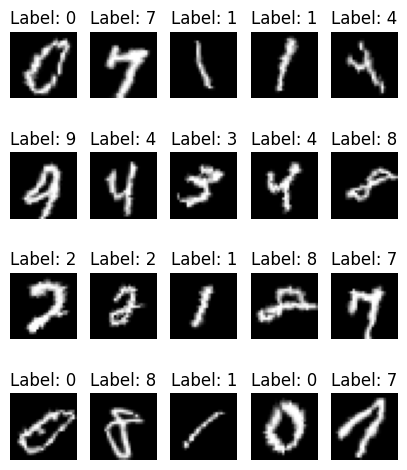

In [25]:
# Plot examples of transformations
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for i, ax in enumerate(axs.flatten(), start=1000):
    (image, label) = train_data[i]

    # Save this data for later
    plot_images.append(image)
    plot_labels.append(label)

    # Plot each image
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

In [26]:
import math
def get_output_size(input_size, padding, stride, kernel):   
    return math.floor((input_size + 2*padding - kernel)/stride) + 1

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), padding='same')
        self.conv2 = nn.Conv2d(32, 128, kernel_size=(3, 3), padding='same') # NOTE: change to 64 for NO data aug case
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        # self.conv4 = nn.Conv2d(128, 256, kernel_size=(1, 1), padding='same')
        
        # Pool layers
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        # self.mp2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=1)
        out1 = get_output_size(input_size=28, padding=1, stride=2, kernel=2)
        out2 = get_output_size(input_size=out1, padding=1, stride=2, kernel=2)
        # out3 = get_output_size(input_size=out2, padding=1, stride=2, kernel=2)
        # out4 = get_output_size(input_size=out3, padding=1, stride=2, kernel=2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128) #NOTE: data aug case
        # self.bn2 = nn.BatchNorm2d(64) #NOTE: NO data aug case
        
        self.dropout = nn.Dropout(0.0840742394198019) #NOTE: dropout % for data augmentation case
        # self.dropout = nn.Dropout(0.05693997544066888) #NOTE: dropout % for NO data aug case

        # Output layers
        # self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1)) #needs an x.squeeze
        self.output_layer = nn.Linear(128*out2*out2, 10) # NOTE: change to 64 for NO data aug case
        # Activation
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        Forward pass implementation for the network
        
        :param x: torch.Tensor of shape (batch, 1, 28, 28), input images

        :returns: torch.Tensor of shape (batch, 10), output logits
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.mp(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.mp(x)
        x = self.bn2(x)
        
        # x = self.conv3(x)
        # x = self.relu(x)
        # x = self.mp(x)

        # x = self.conv4(x)
        # x = self.relu(x)
        # x = self.mp(x)

        x = self.dropout(x)
        x = x.view(x.size(0), -1) 
        x = self.output_layer(x)
        return x

In [29]:
inputs = torch.randn((4, 1, 28, 28))
model = ConvNet()
logits = model(inputs)

# Setup training loop


In [30]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()


        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [31]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

# Test the implementation
Train a model for 5 epochs with both custom and PyTorch optimizer.

In [32]:
# LEARNING_RATE = 0.00047797243381032415
LEARNING_RATE = 0.0006381447313977647
NUM_EPOCHS = 20
# WEIGHT_DECAY = 0.005590116797563316
WEIGHT_DECAY = 0.00012098564799135106
torch.manual_seed(0)
model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

In [33]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

# 31 minutes for 10 epochs

Epoch 1 done. Average train loss = 0.54, average train accuracy = 82.815%
Epoch 1 done. Average test loss = 0.08, average test accuracy = 97.700%
Epoch 2 done. Average train loss = 0.24, average train accuracy = 92.368%
Epoch 2 done. Average test loss = 0.06, average test accuracy = 98.020%
Epoch 3 done. Average train loss = 0.20, average train accuracy = 93.620%
Epoch 3 done. Average test loss = 0.05, average test accuracy = 98.580%
Epoch 4 done. Average train loss = 0.18, average train accuracy = 94.530%
Epoch 4 done. Average test loss = 0.05, average test accuracy = 98.400%
Epoch 5 done. Average train loss = 0.16, average train accuracy = 94.912%
Epoch 5 done. Average test loss = 0.04, average test accuracy = 98.600%
Epoch 6 done. Average train loss = 0.15, average train accuracy = 95.300%
Epoch 6 done. Average test loss = 0.05, average test accuracy = 98.460%
Epoch 7 done. Average train loss = 0.15, average train accuracy = 95.455%
Epoch 7 done. Average test loss = 0.04, average te

# Plot the training curve

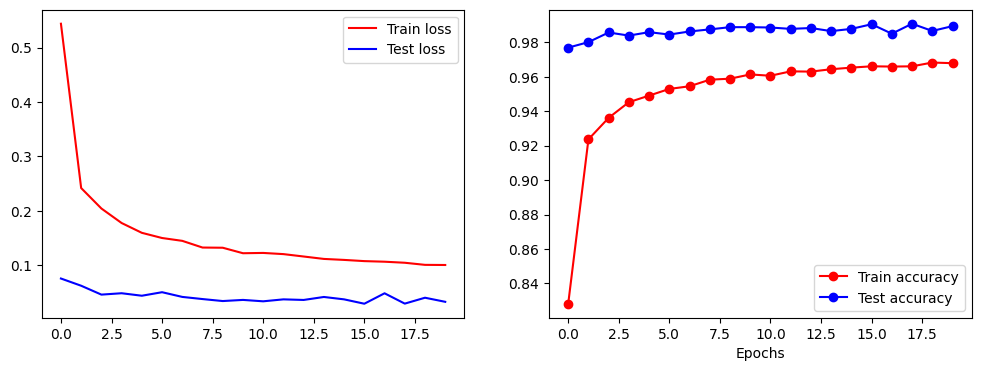

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_losses, c="r", label="Train loss")
axs[0].plot(test_losses, c="b", label="Test loss")
axs[0].legend()
axs[1].set_xlabel("Epochs")

axs[1].plot(train_metrics, "o-", c="r", label="Train accuracy")
axs[1].plot(test_metrics, "o-", c="b", label="Test accuracy")
axs[1].legend()
axs[1].set_xlabel("Epochs")

plt.show()